In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# std mean 구하기

In [3]:
transform = transforms.Compose(
                [transforms.ToTensor()]
            )
trainset = torchvision.datasets.CIFAR10(root = './data', train= True, download = True, transform = transform)

print(trainset.data.shape)
train_data_mean = trainset.data.mean(axis =(0,1,2))
train_data_std = trainset.data.std(axis =(0,1,2))

print(train_data_mean, train_data_std)

train_data_mean = train_data_mean/ 255
train_data_std = train_data_std / 255

print(train_data_mean, train_data_std)

Files already downloaded and verified
(50000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318] [62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [4]:
transform = transforms.Compose(
                [transforms.RandomCrop(32, padding = 4),
                 transforms.ToTensor(),
                 transforms.Normalize(train_data_mean, train_data_std)]
            )
trainset = torchvision.datasets.CIFAR10(root = './data', train= True, download = True, transform = transform)
testset = torchvision.datasets.CIFAR10(root = './data', train= False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 512,
                                         shuffle = True, num_workers = 4)

testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                         shuffle = False, num_workers = 4)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img  = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


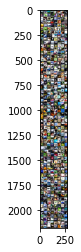

 shiphorse bird frog


In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
def conv3x3(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, 
                    bias = False)

def conv1x1(in_planes, out_planes, stride = 1):
    return nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride, bias = False)

In [10]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride = 1, downsample = None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        # x.shape 3x64x64
        identity = x
        # identity 3x64x64
        out = self.conv1(x) # 3x3 stride = stride 2
        # out.shape 3x32x32
        out = self.bn1(out)
        out = self.relu(out)
        
        # out.shape 3x32x32
        out = self.conv2(out) # 3x3 stride = 1
        # out.shape 3x32x32
        out = self.bn2(out)
        if self.downsample is not None: # donwsample stride 가 2일 경우 
            # identity 3x64x64
            identity = self.downsample(x)
            # identity 3x32x32
        out += identity
        out = self.relu(out)
        return out

In [11]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride = 1, downsample = None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes) # conv1x1 (64, 64)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(inplanes, planes, stride) # conv3x3 (64, 64)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(inplanes, planes * self.expansion) # 4배로 # conv3x3 (64, 256)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace = True)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x) # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out) # 3x3 stride = stride
        out = self.bn2(out)
        out = self.relu(out)
    
        out = self.conv3(out) # 1x1 stride = 1
        out = self.bn3(out)
        
        if self.downsample is not None: 
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [30]:
class ResNet(nn.Module):
    # model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    def __init__(self, block, layers, num_classes = 1000, zero_init_residual = False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)
        
        # inputs = 64x112x112
        #self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        # outputs 64x56x56
        
        # inplanes = 64
        self.layer1 = self._make_layer(block, 16, layers[0], stride = 1) 
        self.layer2 = self._make_layer(block, 32, layers[1], stride = 1) 
        self.layer3 = self._make_layer(block, 64, layers[2], stride = 2) 
        self.layer4 = self._make_layer(block, 128, layers[3], stride = 2) 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight, mode ='fan_out', nonlinearity = 'relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
                    
    def _make_layer(self, block, planes, blocks, stride = 1):
        donwsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: # 64 != 64 * bottelenex 은 4 
            # 64 != 255 channel을 맟주기 위해서도 사용한다. 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), # conv1x1(64, 256, 1)
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        # layers.append(Bottleneck(64, 64, 1, downsample))
        self.inplanes = planes * block.expansion # self.inplanes = 64 * 256 
        for _ in range(1, blocks):
        # for _ in range(1, 3): 2번 된다. 
            # layers.append(block(self.inplanes, planes))
            # layers.append(block(self.inplanes, planes))
            layers.append(block(self.inplanes, planes))
            
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x) # x.shape = [1, 16, 32, 32]
        #x = self.maxpool(x)

        x = self.layer1(x)# x.shape = [1, 128, 32, 32]
        x = self.layer2(x)# x.shape = [1, 256, 32, 32]
        x = self.layer3(x)# x.shape = [1, 512, 32, 32]
        x = self.layer4(x)# x.shape = [1, 1024, 32, 32]
        
        x = self.avgpool(x)
        x = x.view(x.size(0) , -1)
        x = self.fc(x)
        
        return x

In [31]:
resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 10, True).to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [32]:
resnet50

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [33]:
a = torch.Tensor(1, 3, 32, 32).to(device)
out = resnet50(a)
print(out)

torch.Size([1, 16, 32, 32])


RuntimeError: Given groups=1, weight of size [16, 64, 3, 3], expected input[1, 16, 32, 32] to have 64 channels, but got 16 channels instead

In [51]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.005, momentum = 0.9)

lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.9)

In [46]:
print(len(trainloader))

epochs = 50

for epoch in range(epochs):
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 30 == 29:
            print('[%d, %5d] loss : %.3f' % (epoch+1, i +1, running_loss / 30))
            running_loss = 0.0
print("Finished Training")

98


RuntimeError: Given groups=1, weight of size [16, 64, 3, 3], expected input[512, 16, 32, 32] to have 64 channels, but got 16 channels instead

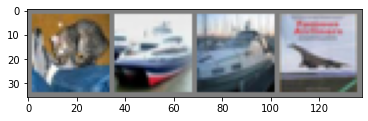

GroundTruth :    cat   ship   ship  plane 


In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print('GroundTruth : ', ' '.join('%5s ' % classes[labels[j]] for j in range(4)))

In [34]:
outputs = resnet50(images.to(device))

In [36]:
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join('%5s ' % classes[predicted[j]] for j in range(4)))

Predicted:  ship   ship   ship  plane 


In [37]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the networ on the 10000 test images: %d %%' % (100* correct /total))

Accuracy of the networ on the 10000 test images: 75 %
